In [8]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from useful_functions import *

In [9]:
#Read CSC 2.1 into dataframe
#filename='/Users/kciurleo/Documents/kciurleo/AGN/unorganized/oldXmatch.csv'
filename='/Users/kciurleo/Documents/kciurleo/AGN/unorganized/CSC2.1p_OIR_SDSSspecmatch.csv'
data=pd.read_csv(filename)

/var/folders/6x/hz5y30457mqg1y9dl2fg7r5m00034d/T/ipykernel_51706/1925374468.py:4: DtypeWarning: Columns (57,61,62) have mixed types. Specify dtype option on import or set low_memory=False.
  data=pd.read_csv(filename)


In [10]:
#Find only sources with SDSS data
sources = data.dropna(subset=['Sep_SPEC_CSC21P'])

#Find only non-extended CSC sources
point_sources = sources.loc[sources['extent_flag']==False]

In [11]:
#Saved point sources as csv, which was used in SciServer CasJobs SQL query to get Portsmouth classifications
point_sources.to_csv('/Users/kciurleo/Documents/kciurleo/AGN/unorganized/point_sources.csv', index=False) 

In [12]:
#Portsmouth classifications https://salims.pages.iu.edu/agn/
portsmouth=pd.read_csv('/Users/kciurleo/Documents/kciurleo/AGN/unorganized/point_sources_classified_lines.csv')

#Agostino classifications https://salims.pages.iu.edu/agn/
agostino=pd.read_csv('/Users/kciurleo/Documents/kciurleo/AGN/unorganized/agostino2021_table1.csv')

In [13]:
#Get the agostino spectral ids and merge into normal agostino table
agostino_IDs=pd.read_csv('/Users/kciurleo/Documents/kciurleo/AGN/unorganized/agostino_specIDs.csv')
agostino_full =pd.merge(agostino_IDs, agostino, left_on=['objID'], right_on=['SDSS_ObjID'], how='inner')

#Combine our point source table, portsmouth classification, and agostine classifications
combined = pd.merge(point_sources, portsmouth, left_on=['PLATE', 'MJD', 'FIBERID'],right_on=['plate', 'mjd', 'fiberID'], how='left')
classified_point_sources = pd.merge(combined, agostino_full, left_on =['specobjID'],right_on=['specobjID'],how='left')

In [14]:
#Find only Seyfert Galaxies, classified as bpt="Seyfert" for Portsmouth and sl_class1=1 for Agostino
portsmouth_s2=classified_point_sources.loc[classified_point_sources['bpt']=="Seyfert"]
agostino_s2=classified_point_sources.loc[classified_point_sources['sl_class1']==1]

#Those classified by both
inner_s2=pd.merge(agostino_s2, portsmouth_s2, how='inner')

#Those classified by either
outer_s2=pd.merge(agostino_s2, portsmouth_s2, how='outer')


In [15]:
print(f'Total observations in crossmatch: {len(data)}')
print(f'All source count: {len(sources)}, {len(data)-len(sources)} not observed with SDSS')
print(f'Point source count: {len(point_sources)}, {len(sources)-len(point_sources)} extended sources')
print()
print(f'Portsmouth Seyferts:{len(portsmouth_s2)}, {len(point_sources)-len(portsmouth_s2)} non-Seyferts')
print(f'Agostino Seyferts: {len(agostino_s2)}, {len(point_sources)-len(agostino_s2)} non-Seyferts')
print()
print(f'Portsmouth-Agostino Seyferts: {len(inner_s2)}')
print(f'Portsmouth or Agostino Seyferts: {len(outer_s2)}')
print()
print(f'Marginal likelihood Portsmouth AGN: {len(portsmouth_s2.loc[portsmouth_s2["likelihood_class"]=="MARGINAL"])}')
print(f'Marginal likelihood Agostino AGN: {len(agostino_s2.loc[agostino_s2["likelihood_class"]=="MARGINAL"])}')

Total observations in crossmatch: 387441
All source count: 17666, 369775 not observed with SDSS
Point source count: 16022, 1644 extended sources

Portsmouth Seyferts:660, 15362 non-Seyferts
Agostino Seyferts: 130, 15892 non-Seyferts

Portsmouth-Agostino Seyferts: 73
Portsmouth or Agostino Seyferts: 717

Marginal likelihood Portsmouth AGN: 72
Marginal likelihood Agostino AGN: 10


In [16]:
#What do the extra agostino seyferts look like in the portsmouth categorization?
unique_to_agostino = pd.merge(agostino_s2, inner_s2, how='left', indicator=True)
unique_to_agostino = unique_to_agostino[unique_to_agostino['_merge'] == 'left_only'].drop(columns=['_merge'])
unique_to_agostino['bpt'].unique()

array(['Composite', 'LINER', 'Star Forming'], dtype=object)

In [17]:
#Ke01 SFR cutoffs from Kewley et al. (2006)
kxNII=np.linspace(-4,0.4,1000)
ke01NII=0.61/(kxNII-0.47)+1.19

kxSII=np.linspace(-4,0.2,1000)
ke01SII=0.72/(kxSII-0.32)+1.30

kxOI=np.linspace(-4,-.8,1000)
ke01OI=0.73/(kxOI+0.59)+1.33

#Ka03 pure star formation line, for [NII] only
kaxNII=np.linspace(-1.2,-.01,1000)
ka03NII=0.61/(kaxNII-0.05)+1.3

#Seyfert/LINER distinctions, for [SII] and [OI] only
slxSII=np.linspace(-0.3,.75,1000)
slSII=1.89*slxSII+0.76

slxOI=np.linspace(-1.1,-.25,1000)
slOI=1.18*slxOI+1.3

In [39]:
#Errors for plotting
y_error=mult_error_prop([classified_point_sources['Flux_OIII_5006'],classified_point_sources['Flux_Hb_4861']], [classified_point_sources['Flux_OIII_5006'], classified_point_sources['Flux_Hb_4861_Err']])

#[NII]


#[SII]
SII_add_x_error=add_error_prop([classified_point_sources['Flux_SII_6730_Err'],classified_point_sources['Flux_SII_6716_Err']])
SII_x_error = mult_error_prop([classified_point_sources['Flux_SII_6730']+classified_point_sources['Flux_SII_6716'],classified_point_sources['Flux_Ha_6562']], [SII_add_x_error, classified_point_sources['Flux_Ha_6562_Err']])

#[OI]

/Users/kciurleo/Documents/kciurleo/AGN/useful_functions.py:28: RuntimeWarning: divide by zero encountered in divide
  return(np.sqrt(np.sum((error_array/value_array)**2, axis=0)))
/Users/kciurleo/Documents/kciurleo/AGN/useful_functions.py:28: RuntimeWarning: invalid value encountered in divide
  return(np.sqrt(np.sum((error_array/value_array)**2, axis=0)))


/Users/kciurleo/.conda/envs/ciao-4.16/lib/python3.11/site-packages/matplotlib/axes/_axes.py:3683: RuntimeWarning: invalid value encountered in add
  low, high = dep + np.vstack([-(1 - lolims), 1 - uplims]) * err


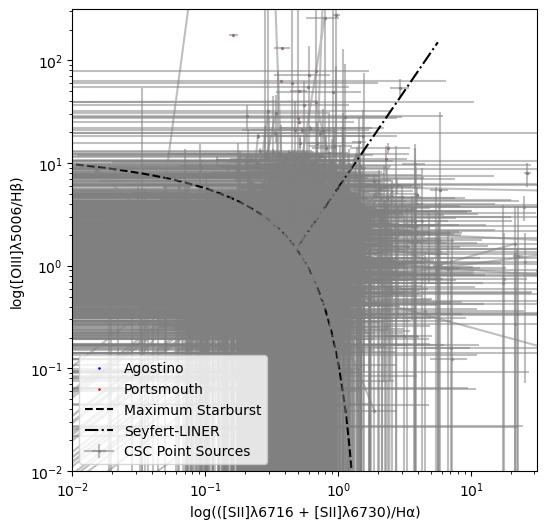

In [40]:
#bpt diagrams
plt.figure(figsize=(6,6))

plt.errorbar(((classified_point_sources['Flux_SII_6730']+classified_point_sources['Flux_SII_6716'])/classified_point_sources['Flux_Ha_6562']),(classified_point_sources['Flux_OIII_5006']/classified_point_sources['Flux_Hb_4861']), marker='.', markersize=3,color='gray', alpha=0.5, label='CSC Point Sources',yerr=y_error,xerr=SII_x_error)
plt.scatter(((agostino_s2['Flux_SII_6730']+agostino_s2['Flux_SII_6716'])/agostino_s2['Flux_Ha_6562']),(agostino_s2['Flux_OIII_5006']/agostino_s2['Flux_Hb_4861']), marker='.',s=3, c='blue', label='Agostino')
plt.scatter(((portsmouth_s2['Flux_SII_6730']+portsmouth_s2['Flux_SII_6716'])/portsmouth_s2['Flux_Ha_6562']),(portsmouth_s2['Flux_OIII_5006']/portsmouth_s2['Flux_Hb_4861']), marker='.',s=3, c='red', label='Portsmouth')
plt.plot(10**kxSII, 10**ke01SII, color='black', linestyle='dashed',label='Maximum Starburst')
plt.plot(10**slxSII, 10**slSII, color='black', linestyle='-.',label='Seyfert-LINER')

plt.xlabel("log(([SII]λ6716 + [SII]λ6730)/Hα)")
plt.ylabel("log([OIII]λ5006/Hβ)")
#note these limits are here because of some weird outliers
plt.xscale('log')
plt.yscale('log')
plt.xlim(10**-2,10**1.5)
plt.ylim(10**-2,10**2.5)
plt.legend(loc='lower left')

plt.show()

/Users/kciurleo/.conda/envs/ciao-4.16/lib/python3.11/site-packages/pandas/core/arraylike.py:399: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
/Users/kciurleo/.conda/envs/ciao-4.16/lib/python3.11/site-packages/pandas/core/arraylike.py:399: RuntimeWarning: invalid value encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)


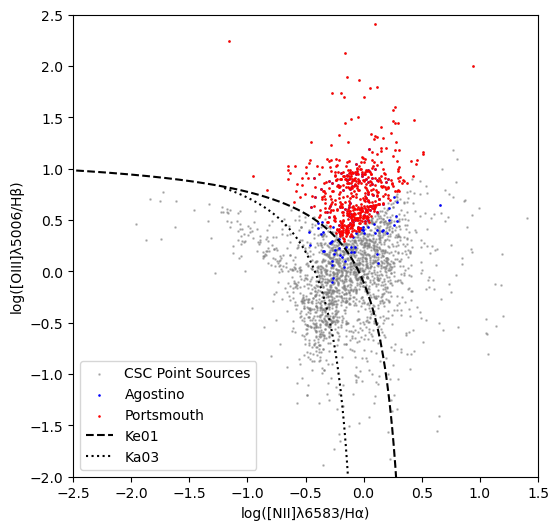

In [18]:
#bpt diagrams
plt.figure(figsize=(6,6))

plt.scatter(np.log10(classified_point_sources['Flux_NII_6583']/classified_point_sources['Flux_Ha_6562']),np.log10(classified_point_sources['Flux_OIII_5006']/classified_point_sources['Flux_Hb_4861']), s=3,c='gray',marker='.', alpha=0.5, label='CSC Point Sources')
plt.scatter(np.log10(agostino_s2['Flux_NII_6583']/agostino_s2['Flux_Ha_6562']),np.log10(agostino_s2['Flux_OIII_5006']/agostino_s2['Flux_Hb_4861']), marker='.', s=3, c='blue', label='Agostino')
plt.scatter(np.log10(portsmouth_s2['Flux_NII_6583']/portsmouth_s2['Flux_Ha_6562']),np.log10(portsmouth_s2['Flux_OIII_5006']/portsmouth_s2['Flux_Hb_4861']), marker='.', s=3, c='red', label='Portsmouth')
plt.plot(kxNII, ke01NII, color='black', linestyle='dashed',label='Ke01')
plt.plot(kaxNII, ka03NII, color='black', linestyle='dotted',label='Ka03')

plt.xlabel("log([NII]λ6583/Hα)")
plt.ylabel("log([OIII]λ5006/Hβ)")
#note these limits are here because of some weird outliers
plt.xlim(-2.5,1.5)
plt.ylim(-2,2.5)
plt.legend(loc='lower left')

plt.show()

/Users/kciurleo/.conda/envs/ciao-4.16/lib/python3.11/site-packages/pandas/core/arraylike.py:399: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
/Users/kciurleo/.conda/envs/ciao-4.16/lib/python3.11/site-packages/pandas/core/arraylike.py:399: RuntimeWarning: invalid value encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)


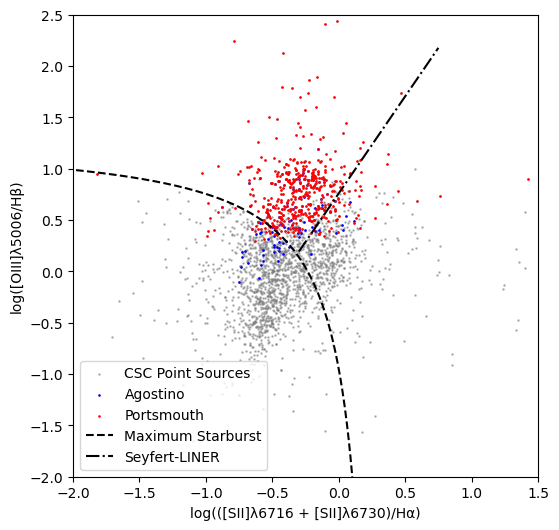

In [30]:
#bpt diagrams
plt.figure(figsize=(6,6))

plt.scatter(np.log10((classified_point_sources['Flux_SII_6730']+classified_point_sources['Flux_SII_6716'])/classified_point_sources['Flux_Ha_6562']),np.log10(classified_point_sources['Flux_OIII_5006']/classified_point_sources['Flux_Hb_4861']), marker='.', s=3,color='gray', alpha=0.5, label='CSC Point Sources')
plt.scatter(np.log10((agostino_s2['Flux_SII_6730']+agostino_s2['Flux_SII_6716'])/agostino_s2['Flux_Ha_6562']),np.log10(agostino_s2['Flux_OIII_5006']/agostino_s2['Flux_Hb_4861']), marker='.',s=3, c='blue', label='Agostino')
plt.scatter(np.log10((portsmouth_s2['Flux_SII_6730']+portsmouth_s2['Flux_SII_6716'])/portsmouth_s2['Flux_Ha_6562']),np.log10(portsmouth_s2['Flux_OIII_5006']/portsmouth_s2['Flux_Hb_4861']), marker='.',s=3, c='red', label='Portsmouth')
plt.plot(kxSII, ke01SII, color='black', linestyle='dashed',label='Maximum Starburst')
plt.plot(slxSII, slSII, color='black', linestyle='-.',label='Seyfert-LINER')

plt.xlabel("log(([SII]λ6716 + [SII]λ6730)/Hα)")
plt.ylabel("log([OIII]λ5006/Hβ)")
#note these limits are here because of some weird outliers
plt.xlim(-2,1.5)
plt.ylim(-2,2.5)
plt.legend(loc='lower left')

plt.show()

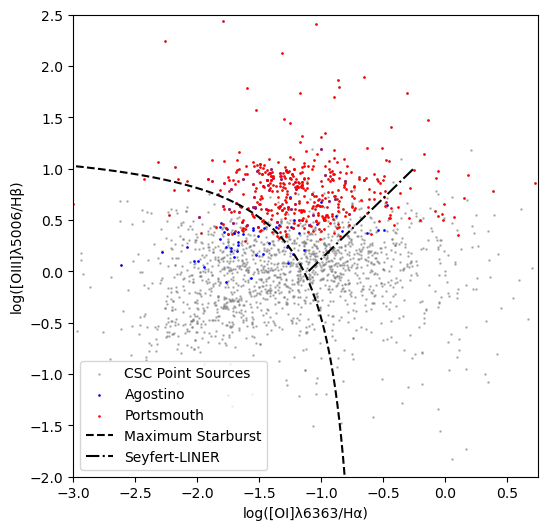

In [20]:
#bpt diagrams
plt.figure(figsize=(6,6))

plt.scatter(np.log10((classified_point_sources['Flux_OI_6363'])/classified_point_sources['Flux_Ha_6562']),np.log10(classified_point_sources['Flux_OIII_5006']/classified_point_sources['Flux_Hb_4861']), marker='.', s=3,color='gray', alpha=0.5, label='CSC Point Sources')
plt.scatter(np.log10((agostino_s2['Flux_OI_6363'])/agostino_s2['Flux_Ha_6562']),np.log10(agostino_s2['Flux_OIII_5006']/agostino_s2['Flux_Hb_4861']), marker='.',s=3, c='blue', label='Agostino')
plt.scatter(np.log10((portsmouth_s2['Flux_OI_6363'])/portsmouth_s2['Flux_Ha_6562']),np.log10(portsmouth_s2['Flux_OIII_5006']/portsmouth_s2['Flux_Hb_4861']), marker='.',s=3, c='red', label='Portsmouth')
plt.plot(kxOI, ke01OI, color='black', linestyle='dashed',label='Maximum Starburst')
plt.plot(slxOI, slOI, color='black', linestyle='-.',label='Seyfert-LINER')

plt.xlabel("log([OI]λ6363/Hα)")
plt.ylabel("log([OIII]λ5006/Hβ)")
#note these limits are here because of some weird outliers
plt.xlim(-3,.75)
plt.ylim(-2,2.5)
plt.legend(loc='lower left')

plt.show()

array([ 0.        , 30.22487724, 13.07145698, ...,         nan,
               nan,         nan])

In [193]:
classified_point_sources.columns

Index(['CSC21P_name', 'ra', 'dec', 'likelihood_class', 'extent_flag',
       'err_ellipse_r0', 'err_ellipse_r1', 'err_ellipse_ang', 'significance',
       'flux_aper_b', 'flux_aper_lolim_b', 'flux_aper_hilim_b', 'flux_aper_h',
       'flux_aper_lolim_h', 'flux_aper_hilim_h', 'flux_aper_m',
       'flux_aper_lolim_m', 'flux_aper_hilim_m', 'flux_aper_s',
       'flux_aper_lolim_s', 'flux_aper_hilim_s', 'flux_aper_w',
       'flux_aper_lolim_w', 'flux_aper_hilim_w', 'csc2.1_flag', 'PS21P_objID',
       'PS21P_ippObjID', 'PS21P_ra', 'PS21P_dec', 'Sep_PS21P_CSC21P',
       'PS21P_g', 'PS21P_r', 'PS21P_i', 'PS21P_z', 'GAIA21P_source_id',
       'GAIA21P_ra', 'GAIA21P_dec', 'Sep_GAIA21P_CSC21P', 'GAIA21P_g',
       'LEG21P_LS_ID', 'LEG21P_OBJID', 'LEG21P_RA', 'LEG21P_DEC',
       'Sep_LEG21P_CSC21P', 'LEG21P_G', 'LEG21P_R', 'LEG21P_Z',
       '2MASS21P_designation', '2MASS21P_ra', '2MASS21P_dec',
       'Sep_2MASS21P_CSC21P', '2MASS21P_j_m', '2MASS21P_h_m', '2MASS21P_k_m',
       'PLUG_RA', '

In [172]:
errors=[[1,2],[2,4],[3,4]]
values=[[1,1],[2,2],[3,3]]
error_array=np.asarray(errors)
value_array=np.asarray(values)

np.sqrt(np.sum((error_array/value_array)**2, axis=0))

array([1.73205081, 3.12694384])

In [176]:
mult_error_prop(values, errors)

array([1.73205081, 3.12694384])

In [5]:
import sys

In [7]:
sys.path.append('/Users/kciurleo/Documents/kciurleo/AGN')